<a href="https://colab.research.google.com/github/infomon/understanding_cnn/blob/master/notebooks/FCN_vs_CNN_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compare FCN vs. CNN

## Imports

In [2]:
!pip install -q git+https://github.com/albermax/innvestigate
!git clone https://github.com/infomon/understanding_cnn
import shutil
import os
if not os.path.isfile("utils.py"):
  shutil.move("/content/understanding_cnn/utils/utils.py", "/content")
if not os.path.isfile("utils_mnist.py"):
  shutil.move("/content/understanding_cnn/utils/utils_mnist.py", "/content")
!rm -r understanding_cnn

Cloning into 'understanding_cnn'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 325 (delta 47), reused 14 (delta 5), pack-reused 221
Receiving objects: 100% (325/325), 39.44 MiB | 30.92 MiB/s, done.
Resolving deltas: 100% (150/150), done.


In [0]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [4]:
%matplotlib inline  

import imp
import numpy as np
import os

import keras
import keras.backend
import keras.models
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

import innvestigate
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "utils.py")
mnistutils = imp.load_source("utils_mnist", "utils_mnist.py")

Using TensorFlow backend.


## Data
Load the dataset for training and testing

In [0]:
# Load data
# returns x_train, y_train, x_test, y_test as numpy.ndarray
data_not_preprocessed = mnistutils.fetch_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(data_not_preprocessed[0], input_range)

# Preprocess data
data = (
    preprocess(data_not_preprocessed[0]), data_not_preprocessed[1],
    preprocess(data_not_preprocessed[2]), data_not_preprocessed[3]
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

x_train, y_train, x_test, y_test = data
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Model
The next part trains and evaluates a CNN

In [13]:
batch_size = 128
epochs = 15
input_shape = (28, 28, 1)

cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3),
                activation='relu',
                 input_shape=input_shape))
cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(num_classes, activation='softmax'))

cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

mcp_save = ModelCheckpoint('cnn_MNIST_model.hdf5', save_best_only=True, monitor='val_acc', mode='max')

cnn.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[mcp_save],
          validation_data=(x_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 5s 83us/step - loss: 0.2554 - acc: 0.9222 - val_loss: 0.0529 - val_acc: 0.9827
Epoch 2/15
60000/60000 [==============================] - 4s 74us/step - loss: 0.0948 - acc: 0.9719 - val_loss: 0.0378 - val_acc: 0.9869
Epoch 3/15
60000/60000 [==============================] - 4s 74us/step - loss: 0.0740 - acc: 0.9780 - val_loss: 0.0327 - val_acc: 0.9894
Epoch 4/15
60000/60000 [==============================] - 4s 74us/step - loss: 0.0578 - acc: 0.9828 - val_loss: 0.0316 - val_acc: 0.9904
Epoch 5/15
60000/60000 [==============================] - 4s 74us/step - loss: 0.0503 - acc: 0.9848 - val_loss: 0.0323 - val_acc: 0.9901
Epoch 6/15
60000/60000 [==============================] - 4s 74us/step - loss: 0.0427 - acc: 0.9864 - val_loss: 0.0367 - val_acc: 0.9885
Epoch 7/15
60000/60000 [==============================] - 4s 74us/step - loss: 0.0375 - acc: 0.9882 - val_loss: 0.0266 - val_acc

In [14]:
batch_size = 128   
epochs = 15

fcn = Sequential()
fcn.add(Flatten(input_shape=(28,28,1)))
fcn.add(Dense(400, activation='relu'))
fcn.add(Dense(200, activation='relu'))
fcn.add(Dropout(0.25))
fcn.add(Dense(100, activation='relu'))
fcn.add(Dense(20, activation='relu'))
fcn.add(Dropout(0.5))
fcn.add(Dense(10, activation='softmax')) 

# Compilation
fcn.compile(loss='categorical_crossentropy', 
    metrics=['accuracy'], optimizer='adam')
fcn.summary()

mcp_save = ModelCheckpoint('fcn_MNIST_model.hdf5', save_best_only=True, monitor='val_acc', mode='max')

fcn.fit(x_train, y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=1,
          callbacks=[mcp_save],
          validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 400)               314000    
_________________________________________________________________
dense_11 (Dense)             (None, 200)               80200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_13 (Dense)             (None, 20)                2020      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
__________

In [0]:
# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    return revert_preprocessing(X) / 255

noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input


# Configure analysis methods and properties
# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE
    
    # Show input
    ("input",                 {},                       input_postprocessing,      "Input"),

    # Function
    ("gradient", {"postprocess": "abs"}, mnistutils.graymap, "Gradient"),  # 0
    ("smoothgrad", {"noise_scale": noise_scale,
                    "postprocess": "square"}, mnistutils.graymap, "SmoothGrad"),  # 1

    # Signal
    ("deconvnet", {}, mnistutils.bk_proj, "Deconvnet"),  # 2
    ("guided_backprop", {}, mnistutils.bk_proj, "Guided Backprop",),  # 3
    ("pattern.net", {"pattern_type": "relu"}, mnistutils.bk_proj, "PatternNet"),  # 4

    # Interaction
    ("pattern.attribution", {"pattern_type": "relu"}, mnistutils.heatmap, "PatternAttribution"),  # 5
    ("deep_taylor.bounded", {"low": input_range[0],
                                 "high": input_range[1]}, mnistutils.heatmap, "DeepTaylor"),  # 6
    ("input_t_gradient", {}, mnistutils.heatmap, "Input * Gradient"),  # 7
    ("integrated_gradients", {"reference_inputs": ri}, mnistutils.heatmap, "Integrated Gradients"),  # 8
    #("lrp.z", {}, mnistutils.heatmap, "LRP-Z"),  # 9
    ("lrp.epsilon", {"epsilon": 1}, mnistutils.heatmap, "LRP-Epsilon"),  # 10
    ("lrp.epsilon_IB", {"epsilon": 1}, mnistutils.heatmap, "LRP-Epsilon IB"),  # 11
    ("lrp.alpha_1_beta_0", {}, mnistutils.heatmap, "LRP-Alpha1-Beta0"),  # 12
    ("lrp.alpha_1_beta_0_IB", {}, mnistutils.heatmap, "LRP-Alpha1-Beta0 IB"),  # 13
        ("lrp.sequential_preset_a_flat",{"epsilon": 1},     mnistutils.heatmap,       "LRP-PresetAFlat"), #14
      ("lrp.sequential_preset_b_flat",{"epsilon": 1},     mnistutils.heatmap,       "LRP-PresetBFlat"), #15
    ]

In [59]:
# Select methods of your choice
selected_methods_indices = [0,6,7,11,13]
selected_methods = [methods[i] for i in selected_methods_indices]
print('Using method(s) "{}".'.format([method[0] for method in selected_methods]))


Using method(s) "['input', 'pattern.attribution', 'deep_taylor.bounded', 'lrp.epsilon_IB', 'lrp.alpha_1_beta_0_IB']".


In [66]:
n = 30

models = [cnn,fcn]
test_images = list(zip(data[2][:n], data[3][:n]))

analysis = np.zeros([len(models),len(test_images), len(selected_methods), 28, 28, 3])
text = []

for j,model in enumerate(models):
  # Create model without trailing softmax
  model_wo_softmax = iutils.keras.graph.model_wo_softmax(models[j])

  # Create analyzers.
  analyzers = []
  for method in selected_methods:
    try:
        analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                                model_wo_softmax, # model without softmax output
                                                **method[1])      # optional analysis parameters
        # Some analyzers require training.
        analyzer.fit(data[0], batch_size=256, verbose=1)
    
    except innvestigate.NotAnalyzeableModelException as e:
          analyzer = None
          print(method[3]+" cannot be used!")
          print(str(e))
    analyzers.append(analyzer)
    
  for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]
      
    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x)[0]
    prob = models[j].predict_on_batch(x)[0]
    y_hat = prob.argmax()
      
    # Save prediction info:
    text.append(("%s" % label_to_class_name[y],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % y # predicted label
                ))
      
    for aidx, analyzer in enumerate(analyzers):
      # Analyze.
      a = analyzer.analyze(x)
        
      # Apply common postprocessing, e.g., re-ordering the channels for plotting.
      a = mnistutils.postprocess(a)
      # Apply analysis postprocessing, e.g., creating a heatmap.
      a = selected_methods[aidx][2](a)
      # Store the analysis
      analysis[j, i, aidx] = a[0]

Epoch 1/1
235/235 [==============================] - 10s 42ms/step - loss: 4.0000 - broadcast_36_loss: 1.0000 - broadcast_37_loss: 1.0000 - broadcast_38_loss: 1.0000 - broadcast_39_loss: 1.0000
Epoch 1/1
235/235 [==============================] - 7s 29ms/step - loss: 5.0000 - broadcast_40_loss: 1.0000 - broadcast_41_loss: 1.0000 - broadcast_42_loss: 1.0000 - broadcast_43_loss: 1.0000 - broadcast_44_loss: 1.0000


In [71]:
print(text[4],text[4+30])

('4', '20.82', '1.00', '4') ('4', '20.76', '1.00', '4')


## Analysis

Image nr. 0, true label: 7


<Figure size 432x288 with 0 Axes>

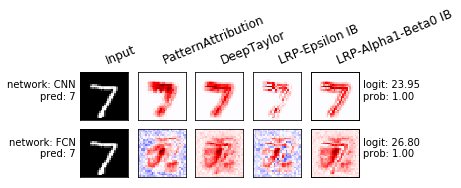

Image nr. 1, true label: 2


<Figure size 432x288 with 0 Axes>

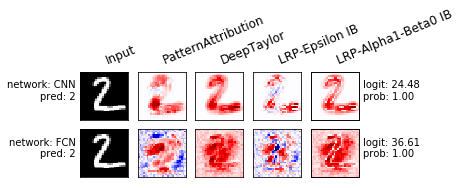

Image nr. 2, true label: 1


<Figure size 432x288 with 0 Axes>

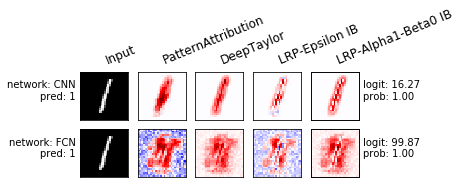

Image nr. 3, true label: 0


<Figure size 432x288 with 0 Axes>

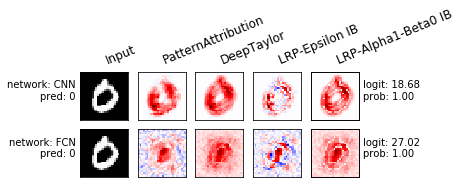

Image nr. 4, true label: 4


<Figure size 432x288 with 0 Axes>

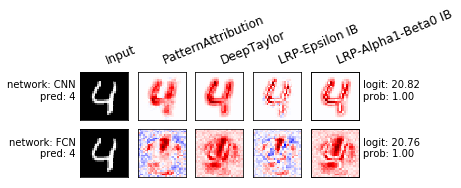

Image nr. 5, true label: 1


<Figure size 432x288 with 0 Axes>

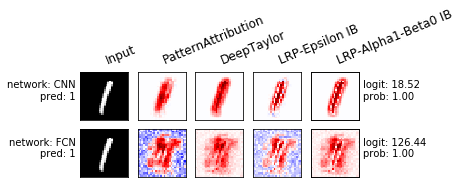

Image nr. 6, true label: 4


<Figure size 432x288 with 0 Axes>

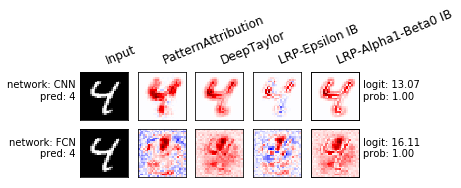

Image nr. 7, true label: 9


<Figure size 432x288 with 0 Axes>

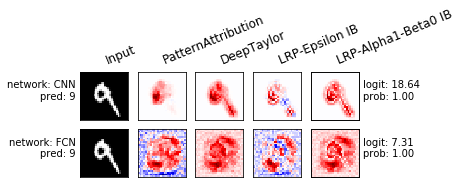

Image nr. 8, true label: 5


<Figure size 432x288 with 0 Axes>

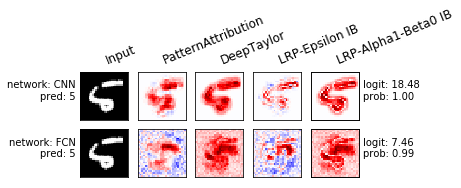

Image nr. 9, true label: 9


<Figure size 432x288 with 0 Axes>

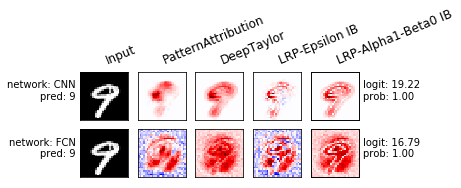

Image nr. 10, true label: 0


<Figure size 432x288 with 0 Axes>

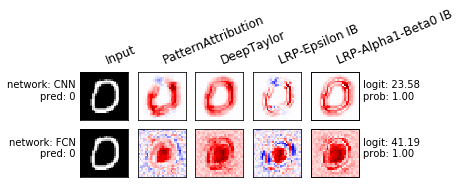

Image nr. 11, true label: 6


<Figure size 432x288 with 0 Axes>

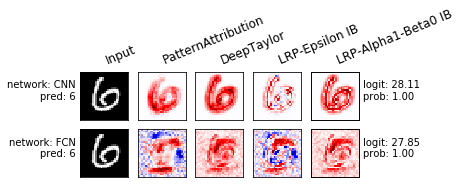

Image nr. 12, true label: 9


<Figure size 432x288 with 0 Axes>

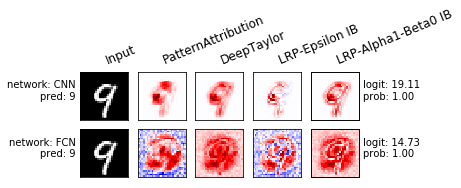

Image nr. 13, true label: 0


<Figure size 432x288 with 0 Axes>

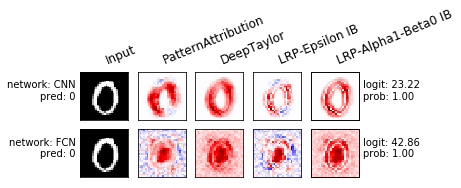

Image nr. 14, true label: 1


<Figure size 432x288 with 0 Axes>

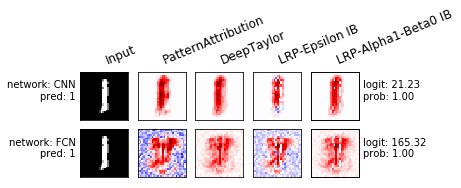

Image nr. 15, true label: 5


<Figure size 432x288 with 0 Axes>

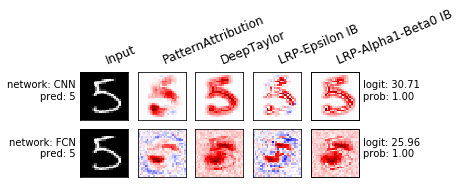

Image nr. 16, true label: 9


<Figure size 432x288 with 0 Axes>

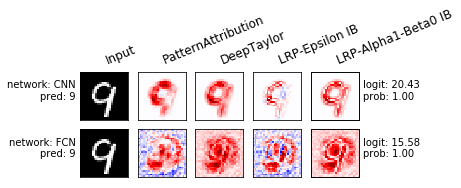

Image nr. 17, true label: 7


<Figure size 432x288 with 0 Axes>

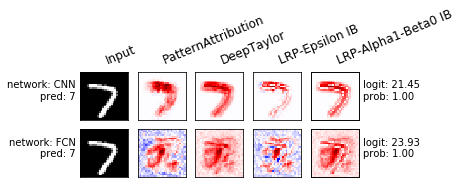

Image nr. 18, true label: 3


<Figure size 432x288 with 0 Axes>

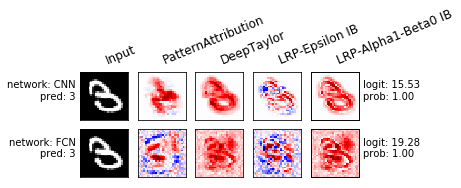

Image nr. 19, true label: 4


<Figure size 432x288 with 0 Axes>

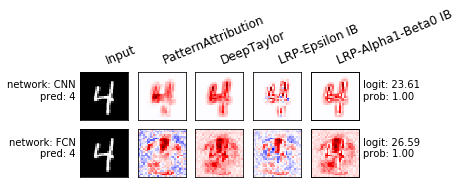

Image nr. 20, true label: 9


<Figure size 432x288 with 0 Axes>

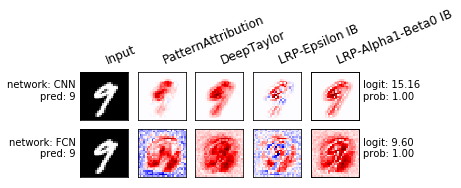

Image nr. 21, true label: 6


<Figure size 432x288 with 0 Axes>

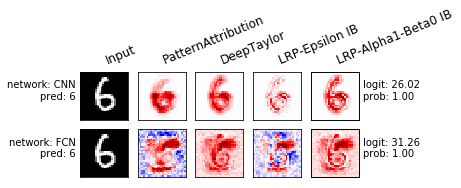

Image nr. 22, true label: 6


<Figure size 432x288 with 0 Axes>

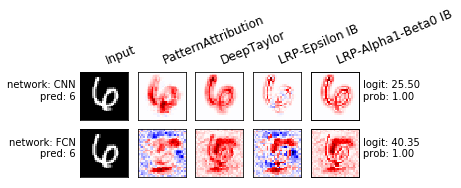

Image nr. 23, true label: 5


<Figure size 432x288 with 0 Axes>

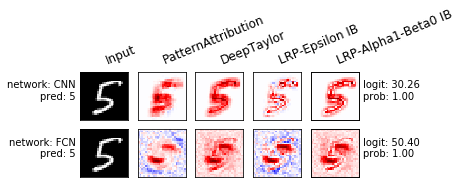

Image nr. 24, true label: 4


<Figure size 432x288 with 0 Axes>

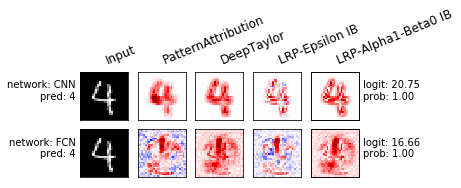

Image nr. 25, true label: 0


<Figure size 432x288 with 0 Axes>

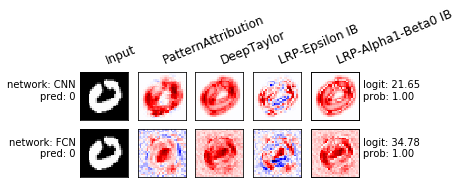

Image nr. 26, true label: 7


<Figure size 432x288 with 0 Axes>

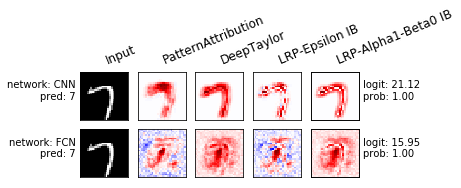

Image nr. 27, true label: 4


<Figure size 432x288 with 0 Axes>

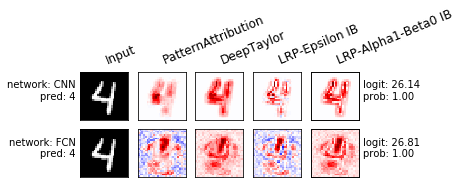

Image nr. 28, true label: 0


<Figure size 432x288 with 0 Axes>

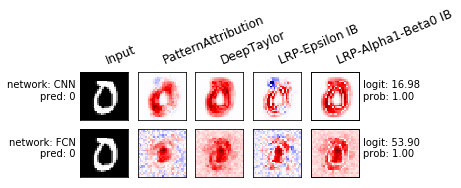

Image nr. 29, true label: 1


<Figure size 432x288 with 0 Axes>

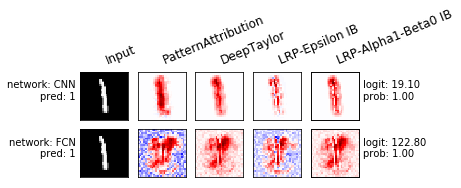

In [72]:
import matplotlib as plt

n_images = 30

model_names = ["CNN","FCN"]

# Prepare common labels
col_labels = [''.join(method[3]) for method in selected_methods]

for image_index in range(n_images):
    grid = []
    row_labels_left = []
    row_labels_right = []
    
    for i,_ in enumerate(models):
        a, t = analysis[i, image_index], text[image_index+30*i]
        # Prepare the grid as rectengular list
        grid.append([a[j] for j in range(len(analyzers))])
        # Prepare the labels
        label, presm, prob, pred = zip(t)
        label = label[0]
        row_labels_left.append(('network: {}'.format(model_names[i]),'pred: {}'.format(pred[0])))
        row_labels_right.append(('logit: {}'.format(presm[0]),'prob: {}'.format(prob[0])))

    # Plot the analysis.
    print("Image nr. {}, true label: {}".format(image_index, label))
    eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                           file_name=os.environ.get("plot_file_name", None))
